## **Import Libraries**

#### **Paper:** https://arxiv.org/pdf/2401.15884

In [1]:
import time, re
from typing import List, TypedDict
from pydantic import BaseModel

from langchain_tavily import TavilySearch
from langchain_community.document_loaders import PyPDFLoader
from langchain_community.vectorstores import FAISS
from langchain_openai import OpenAIEmbeddings, ChatOpenAI
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_core.documents import Document
from langchain_core.prompts import ChatPromptTemplate
from IPython.display import display, Markdown, Image

from langgraph.graph import StateGraph, START, END
from dotenv import load_dotenv

load_dotenv()

/home/muhammadumerkhan/Gen-Agentic-AI-Tutorials/.venv/lib/python3.12/site-packages/langchain_tavily/tavily_research.py:97: UserWarning: Field name "output_schema" in "TavilyResearch" shadows an attribute in parent "BaseTool"
  class TavilyResearch(BaseTool):  # type: ignore[override, override]
/home/muhammadumerkhan/Gen-Agentic-AI-Tutorials/.venv/lib/python3.12/site-packages/langchain_tavily/tavily_research.py:97: UserWarning: Field name "stream" in "TavilyResearch" shadows an attribute in parent "BaseTool"
  class TavilyResearch(BaseTool):  # type: ignore[override, override]


True

### **Load Books**

In [2]:
docs = (
    PyPDFLoader("../../../assets/books/deep_learning.pdf").load() +
    PyPDFLoader("../../../assets/books/hands_on_ml.pdf").load() +
    PyPDFLoader("../../../assets/books/pattern_recognition.pdf").load()
)

- docs length

In [3]:
len(docs)

2123

### **Split Documents into Chunks**

In [4]:
chunks = RecursiveCharacterTextSplitter(chunk_size=900, chunk_overlap=150).split_documents(docs)
for d in chunks:
    d.page_content = d.page_content.encode("utf-8", "ignore").decode("utf-8", "ignore")

### **Embedding and Indexing**

In [5]:
embeddings = OpenAIEmbeddings(model="text-embedding-3-large")
vector_store = FAISS.from_documents(chunks, embeddings)

- **Retriever**

In [6]:
retriever = vector_store.as_retriever(search_type="similarity", search_kwargs={"k": 4})

In [7]:
retrieved_docs = retriever.invoke("Explain the bias–variance tradeoff")

In [8]:
len(retrieved_docs)

4

- **LLM**

In [9]:
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

In [10]:
class State(TypedDict):
    question: str
    docs: List[Document]

    good_docs: List[Document]
    verdict: str
    reason: str
    
    strips: List[str]
    kept_strips: List[str]
    refined_context: str

    web_docs: List[Document]
    web_query: str

    answer: str

In [11]:
def retrieve(state: State) -> State:
    q = state["question"]
    return {"docs": retriever.invoke(q)}

- **Evaluator**

In [12]:
class DocEvalScore(BaseModel):
    score: float
    reason: str

In [13]:
doc_eval_prompt = ChatPromptTemplate.from_messages([
    (
    "system",
        "You are a strict retrieval evaluator for RAG.\n"
        "You will be given ONE retrieved chunk and a question.\n"
        "Return a relevance score in [0.0, 1.0].\n"
        "- 1.0: chunk alone is sufficient to answer fully/mostly\n"
        "- 0.0: chunk is irrelevant\n"
        "Be conservative with high scores.\n"
        "Also return a short reason.\n"
        "Output JSON only."
    ),
    (
    "human", "Question: {question}\n\nChunk:\n{chunk}"
    )
])

In [14]:
doc_eval_chain = doc_eval_prompt | llm.with_structured_output(DocEvalScore)

In [15]:
LOWER_TH = 0.3
UPPER_TH = 0.7

In [16]:
def eval_doc(state: State) -> State:

    q = state["question"]
    
    scores: List[float] = []
    reasons: List[str] = []
    good: List[Document] = []

    for d in state["docs"]:
        out = doc_eval_chain.invoke({"question": q, "chunk": d.page_content})
        scores.append(out.score)
        reasons.append(out.reason)

        # 5) for CORRECT case we will refine only docs with score > LOWER_TH
        if out.score > LOWER_TH:
            good.append(d)

    # 2) CORRECT if at least one doc > UPPER_TH
    if any(s > UPPER_TH for s in scores):
        return {
            "good_docs": good,
            "verdict": "CORRECT",
            "reason": f"At least one retrieved chunk scored > {UPPER_TH}.",
        }

    # 3) INCORRECT if all docs < LOWER_TH
    if len(scores) > 0 and all(s < LOWER_TH for s in scores):
        why = "No chunk was sufficient."
        return {
            "good_docs": [],
            "verdict": "INCORRECT",
            "reason": f"All retrieved chunks scored < {LOWER_TH}. {why}",
        }

    # 4) Anything in between => AMBIGUOUS
    why = "Mixed relevance signals."
    return {
        "good_docs": good,
        "verdict": "AMBIGUOUS",
        "reason": f"No chunk scored > {UPPER_TH}, but not all were < {LOWER_TH}. {why}",
    }

In [17]:
evaluations = eval_doc({
    "question": "Explain the bias–variance tradeoff",
    "docs": retrieved_docs
})

In [18]:
len(evaluations['good_docs'])

4

In [19]:
evaluations['verdict']

'CORRECT'

- **Sentence-level DECOMPOSER**

In [20]:
def decompose_to_sentences(text: str) -> List[str]:
    text = re.sub(r"\s+", " ", text).strip()
    sentences = re.split(r"(?<=[.!?])\s+", text)
    return [s.strip() for s in sentences if len(s.strip()) > 20]

In [21]:
context = "\n\n".join(d.page_content for d in retrieved_docs).strip()
# context

In [22]:
decomposed_context = decompose_to_sentences(context)
len(decomposed_context)

26

**FILTER (LLM judge)**

In [23]:
class KeepDrop(BaseModel):
    keep: bool

filter_prompt = ChatPromptTemplate.from_messages([
    (
    "system",
        "You are a strict relevance filter.\n"
        "Return keep=true only if the sentence directly helps answer the question.\n"
        "Use ONLY the sentence. Output JSON only.",
    ),
    (
    "human", "Question: {question}\n\nSentence:\n{sentence}"
    )
])

In [24]:
filter_chain = filter_prompt | llm.with_structured_output(KeepDrop)

#### **REFINING (Decompose -> Filter -> Recompose)**
**Refinement Criteria**
- **CORRECT => internal only**
- **INCORRECT => web only**
- **AMBIGUOUS => internal + web**

In [25]:
def refine(state: State) -> State:
    q = state["question"]

    if state.get("verdict") == "CORRECT":
        doc_to_use = state["good_docs"]
    elif state.get("verdict") == "INCORRECT":
        doc_to_use = state["web_docs"]
    else:
        doc_to_use = state["good_docs"] + state["web_docs"]

    context = "\n\n".join(d.page_content for d in doc_to_use).strip()

    strips = decompose_to_sentences(context)

    kept: List[str] = []
    for s in strips:
        if filter_chain.invoke({"question": q, "sentence": s}).keep:
            kept.append(s)

    refined_context = "\n".join(kept).strip()

    return {
        "strips": strips,
        "kept_strips": kept,
        "refined_context": refined_context,
    }

In [26]:
refined = refine({"question": "Explain the bias–variance tradeoff", "good_docs": retrieved_docs, "verdict": "CORRECT"})

In [27]:
# refined['refined_context']

- **RE-WRITE QUERY**

In [28]:
class WebQuery(BaseModel):
    query: str

In [29]:
rewrite_prompt = ChatPromptTemplate.from_messages([
    (
    "system",
        "Rewrite the user question into a web search query composed of keywords.\n"
        "Rules:\n"
        "- Keep it short (6–14 words).\n"
        "- If the question implies recency (e.g., recent/latest/last week/last month), add a constraint like (last 30 days).\n"
        "- Do NOT answer the question.\n"
        "- Return JSON with a single key: query",
    ),
    ("human", "Question: {question}"),
])

In [30]:
rewrite_chain = rewrite_prompt | llm.with_structured_output(WebQuery)

def rewrite(state: State) -> State:
    
    rewritten = rewrite_chain.invoke({"question": state["question"]}).query
    return {"web_query": rewritten}

In [31]:
rewrited = rewrite({"question": "Explain the bias–variance tradeoff"})

In [32]:
rewrited['web_query']

'bias variance tradeoff explanation'

- **WEB SEARCH**

In [33]:
def websearch(state: State) -> State:

    search_engine = TavilySearch(max_results=5)
    q = state["question"]
    results = search_engine.invoke({"query": q})

    web_docs = []
    for r in results["results"] or []:

        title = r.get("title", "")
        url = r.get("url", "")
        content = r.get("content") or r.get("snippet") or ""

        text = f"TITLE: {title}\nURL: {url}\nCONTENT: {content}"

        web_docs.append(Document(page_content=text, metadata={"title": title, "url": url}))
    
    return {"web_docs": web_docs}

In [34]:
web_searched = websearch({"question": "Explain the bias–variance tradeoff"})

In [35]:
# web_searched['web_docs'][0].page_content

- **ANSWER GENERATION**

In [36]:
answer_prompt = ChatPromptTemplate.from_messages([
    (
    "system",
        "Answer using the provided context when possible. "
        "If the context does not contain relevant information, you may say that information is limited or missing, "
        "but try to provide whatever useful pieces are present.\n"
    ),
    (
    "human", "Question: {question}\n\nRefined context:\n{refined_context}"
    ),
])

In [37]:
def generate_answer(state: State) -> State:
    output = (answer_prompt | llm).invoke({
        "question": state["question"], 
        "refined_context": state["refined_context"]
    })

    return {"answer": output.content}

- **FAIL/AMBIGUOUS NODES**

- Routing: 
    - CORRECT => refine
    - INCORRECT / AMBIGUOUS => rewrite -> web_search -> refine -> generate

In [39]:
def route_node(state: State) -> str:
    if state["verdict"] == "CORRECT":
        return "refiner"
    else:
        return "rewrite"

- **GRAPH**

In [40]:
graph = StateGraph(State)

graph.add_node("retrieve", retrieve)
graph.add_node("eval_doc", eval_doc)
graph.add_node("rewrite_query", rewrite)
graph.add_node("websearch", websearch)
graph.add_node("refine", refine)
graph.add_node("generate_answer", generate_answer)

graph.add_edge(START, "retrieve")
graph.add_edge("retrieve", "eval_doc")

graph.add_conditional_edges(
    "eval_doc", route_node,
    { 
        "refiner":"refine",
        "rewrite": "rewrite_query", 
    }
)

graph.add_edge("rewrite_query", "websearch")
graph.add_edge("websearch", "refine")
graph.add_edge("refine", "generate_answer")

graph.add_edge("generate_answer", END)

rag = graph.compile()

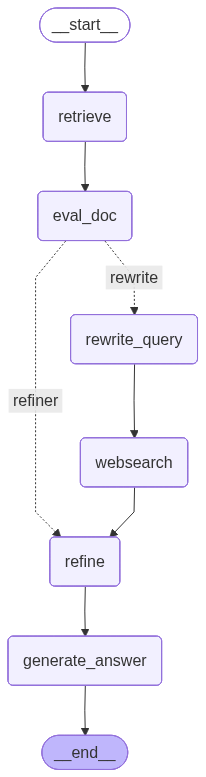

In [41]:
display(Image(rag.get_graph(xray=1).draw_mermaid_png()))

#### **Testing**

In [43]:
def run(question: str) -> dict:
    res = rag.invoke(
        {
            "question": question,
            "docs": [],
            "good_docs": [],
            "verdict": "",
            "reason": "",
            "strips": [],
            "kept_strips": [],
            "refined_context": "",
            "web_docs": [],
            "web_query": "",
            "answer": "",
        }
    )
    return res

In [71]:
res = run("What are attention mechanisms and why are they important in current models?")

In [72]:
res.keys()

dict_keys(['question', 'docs', 'good_docs', 'verdict', 'reason', 'strips', 'kept_strips', 'refined_context', 'web_docs', 'web_query', 'answer'])

In [74]:
print("VERDICT:", res["verdict"])
print("REASON:", res["reason"])
# print("\nOUTPUT:\n", res["answer"])

VERDICT: CORRECT
REASON: At least one retrieved chunk scored > 0.7.


In [76]:
# res['refined_context']

In [77]:
display(Markdown(res["answer"]))

Attention mechanisms are techniques used in neural networks, particularly in natural language processing and computer vision, that allow models to focus on specific parts of the input data when making predictions. Instead of processing all input data uniformly, attention mechanisms enable models to weigh the importance of different elements, effectively allowing them to "attend" to relevant information while ignoring less relevant parts.

The importance of attention mechanisms in current models lies in several key benefits:

1. **Improved Performance**: By focusing on the most relevant parts of the input, attention mechanisms can enhance the performance of models, leading to better accuracy in tasks such as translation, summarization, and image captioning.

2. **Handling Long Sequences**: Traditional models, like recurrent neural networks (RNNs), struggle with long sequences due to issues like vanishing gradients. Attention mechanisms allow models to capture dependencies across long distances in the data more effectively.

3. **Interpretability**: Attention weights can provide insights into which parts of the input the model is focusing on, making the decision-making process more interpretable for users.

4. **Parallelization**: Unlike RNNs, which process data sequentially, attention mechanisms can be computed in parallel, leading to faster training and inference times.

Overall, attention mechanisms have become a foundational component in many state-of-the-art models, such as Transformers, which have revolutionized the field of deep learning.

- Bias variance tradeoff
- AI news from last week
- What are attention mechanisms and why are they important in current models?

In [151]:
res = run("Explain the bias–variance tradeoff")

In [152]:
print("VERDICT:", res["verdict"])
print("REASON:", res["reason"])
# print("\nOUTPUT:\n", res["answer"])

VERDICT: CORRECT
REASON: At least one retrieved chunk scored > 0.7.


In [153]:
display(Markdown(res["answer"]))

The bias–variance tradeoff is a fundamental concept in statistics and machine learning that describes the relationship between bias, variance, and the generalization error of a model. 

- Bias measures the expected deviation from the true value, often due to incorrect assumptions about the data (e.g., assuming linearity when the relationship is quadratic). High-bias models tend to underfit the training data.
- Variance measures the model's sensitivity to small variations in the training data. High-variance models can overfit the training data.
- The generalization error can be expressed as the sum of bias, variance, and a constant noise term.
- There is a trade-off: flexible models have low bias and high variance, while rigid models have high bias and low variance.
- The optimal model achieves the best balance between bias and variance.
- Increasing model complexity typically increases variance and reduces bias, while reducing complexity increases bias and decreases variance.

In [78]:
res = run("AI news from the last month")

In [79]:
print("VERDICT:", res["verdict"])
print("REASON:", res["reason"])
# print("\nOUTPUT:\n", res["answer"])

VERDICT: INCORRECT
REASON: All retrieved chunks scored < 0.3. No chunk was sufficient.


In [82]:
# res['refined_context']

In [81]:
display(Markdown(res["answer"]))

In the last month, notable developments in AI include:

1. **OpenAI's New Releases**: OpenAI launched a new Codex app and introduced GPT-5.3-Codex, which has garnered attention in the AI community.

2. **Anthropic's Developments**: Anthropic has also made significant advancements, although specific details were not provided in the context.

3. **Global AI Initiatives**: Thailand has become one of the first countries in Asia to adopt the Sora app, while Malaysia has launched Ryt Bank, its first AI-powered bank.

4. **Google's Innovations**: Google has introduced Veo 3, a new AI video creation tool, enhancing its suite of AI offerings.

For more detailed coverage, you can explore articles from sources like the Wall Street Journal, Reuters, and various AI news platforms.

In [44]:
res = run("Batch normalization vs layer normalization")

In [45]:
print("VERDICT:", res["verdict"])
print("REASON:", res["reason"])
# print("\nOUTPUT:\n", res["answer"])

VERDICT: AMBIGUOUS
REASON: No chunk scored > 0.7, but not all were < 0.3. Mixed relevance signals.


In [46]:
display(Markdown(res["answer"]))

Batch normalization (BN) and layer normalization (LN) are both techniques used to stabilize and accelerate the training of neural networks, but they differ significantly in their approach and applicability.

### Key Differences:

1. **Normalization Axis**:
   - **Batch Normalization**: Normalizes the inputs across the examples in a mini-batch. This means it computes the mean and variance for each feature across the entire batch.
   - **Layer Normalization**: Normalizes the inputs across the features for each individual example. It computes the mean and variance for each sample independently.

2. **Applicability**:
   - **Batch Normalization**: Generally more effective for feedforward neural networks and convolutional neural networks (CNNs), where the batch size is typically larger and the spatial relationships between examples are important.
   - **Layer Normalization**: More suited for recurrent neural networks (RNNs) and models with variable input lengths, as it does not depend on batch size and provides consistent normalization regardless of the number of examples.

3. **Performance with Batch Size**:
   - **Batch Normalization**: Can lead to complications with small batch sizes or in scenarios like generative adversarial networks (GANs) due to its reliance on batch statistics.
   - **Layer Normalization**: Offers greater flexibility and robustness, especially in situations with small batch sizes or fluctuating data distributions, as it normalizes each example independently.

4. **Training Dynamics**:
   - **Batch Normalization**: Typically accelerates training and improves convergence in larger networks.
   - **Layer Normalization**: While it may not speed up training as effectively as BN in large networks, it stabilizes training in models that deal with long-term dependencies, such as RNNs.

5. **Computational Cost**:
   - **Layer Normalization**: Can be slightly more computationally intensive since it normalizes over a larger set of parameters (all features of a single example).

### Conclusion:
Both normalization techniques have their unique advantages and are tailored for different types of neural network architectures. The choice between batch normalization and layer normalization depends on the specific characteristics of the dataset, the architecture of the neural network, and the computational constraints of the training environment.